# E2C Evaluation (testing)
This is the interactive workflow for E2C evaluation. Some basic visualizations for the results are also included.

Zhaoyang Larry Jin  
Stanford University  
zjin@stanford.edu


## Step 1. Load libraries and config hardware

In [1]:
import h5py
import numpy as np

from train import create_e2c

from keras import backend as K
from keras.layers import Input
from keras.models import Model

import matplotlib.pyplot as plt
plt.set_cmap('jet')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# GPU memory management
import tensorflow as tf
import timeit

Using TensorFlow backend.


In [2]:
# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

## Step 2. Specify params and load model/data

In [3]:
data_dir = '/data3/Astro/personal/zjin/datasets/9W_MS_BHP_RATE_GAU/'
output_dir = './saved_models/' # load model data

case_name = '9w_ms_bhp_rate'
target_suffix = '_fix_wl_rel_8' # the dataset being evaluated here
case_suffix = '_fix_wl_rel_8'
train_suffix = '_with_p'
model_suffix = '_flux_loss'


num_t = 20
run_eval = 100
num_eval = num_t * run_eval
dt = 100

eval_file = case_name + '_e2c_eval' + target_suffix + train_suffix + '_n%d_dt%dday_nt%d_nrun%d.mat'%(num_eval, dt, num_t, run_eval)

state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'

state_data = state_file + target_suffix + '.mat'
ctrl_data = ctrl_file + target_suffix + '.mat'

#### Construct E2C model

In [6]:
latent_dim, u_dim = 50, 9*2
input_shape = (60, 60, 2) # change from _with_p to _no_p
encoder, decoder, transition = create_e2c(latent_dim, u_dim, input_shape)

num_train, latent_dim, learning_rate, epoch = 6000, 50, 1e-4, 10

sigma =  0


#### Load the E2C model saved in the training

In [7]:
encoder.load_weights(output_dir + 'e2c_encoder_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
decoder.load_weights(output_dir + 'e2c_decoder_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
transition.load_weights(output_dir + 'e2c_transition_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))

## Step 3. Task I: E2C single step prediction  

Before you run the workflow to check the E2C results for time-series data. Here is a quick mid-step for you to run E2C for a single timestep. Of course, we will not present the results for this step in the paper or presentation. But this step serve as a good test. It is much easier to debug with this step.

In [8]:
hf_r = h5py.File(data_dir + eval_file, 'r')
state_t_eval = np.array(hf_r.get('state_t'))
state_t1_eval = np.array(hf_r.get('state_t1'))
bhp_eval = np.array(hf_r.get('bhp'))
dt_eval = np.array(hf_r.get('dt'))
hf_r.close()

In [9]:
num_eval = 20 # pick 20 out of 2200 evals
state_t_eval = state_t_eval[:num_eval, ...]
state_t1_eval = state_t1_eval[:num_eval, ...]
bhp_eval = bhp_eval[:num_eval, ...]

#### Construct computation graph (only needed for `Tensorflow 1.x`)

In [10]:
xt = Input(shape=input_shape)
xt1 = Input(shape=input_shape)
ut = Input(shape=(u_dim, ))
dt = Input(shape=(1,))

In [11]:
zt = encoder(xt)
xt_rec = decoder(zt)

zt1_pred = transition([zt, ut, dt])
xt1_pred = decoder(zt1_pred)

e2c_model = Model([xt, ut, dt], [xt_rec, xt1_pred])

#### Run E2C model for a single step and time it

In [12]:
### timer start
start = timeit.default_timer()

### make one step prediction
[state_t_rec, state_t1_pred] = e2c_model.predict([state_t_eval, bhp_eval, dt_eval])

### timer end
end = timeit.default_timer()
print('Time for one step: ', end - start)  

Time for one step:  2.9107066057622433


### Step 3.1 Visualization single step result: saturation

Note here the concept for `reconstruction` and `prediction`.  
`reconstruction`: data(`t`) -> encoder -> decoder -> reconstructed data(`t`)  
`prediction`: data(`t`) -> encoder -> linear transition model -> decoder -> predicted data(`t+1`)

`t` and `t+1` are timesteps.

In [13]:
s_max = 1
s_min = 0
s_diff = s_max - s_min

state_t_eval_plot = state_t_eval * s_diff + s_min
state_t_rec_plot = state_t_rec * s_diff + s_min
state_t1_eval_plot = state_t1_eval * s_diff + s_min
state_t1_pred_plot = state_t1_pred * s_diff + s_min

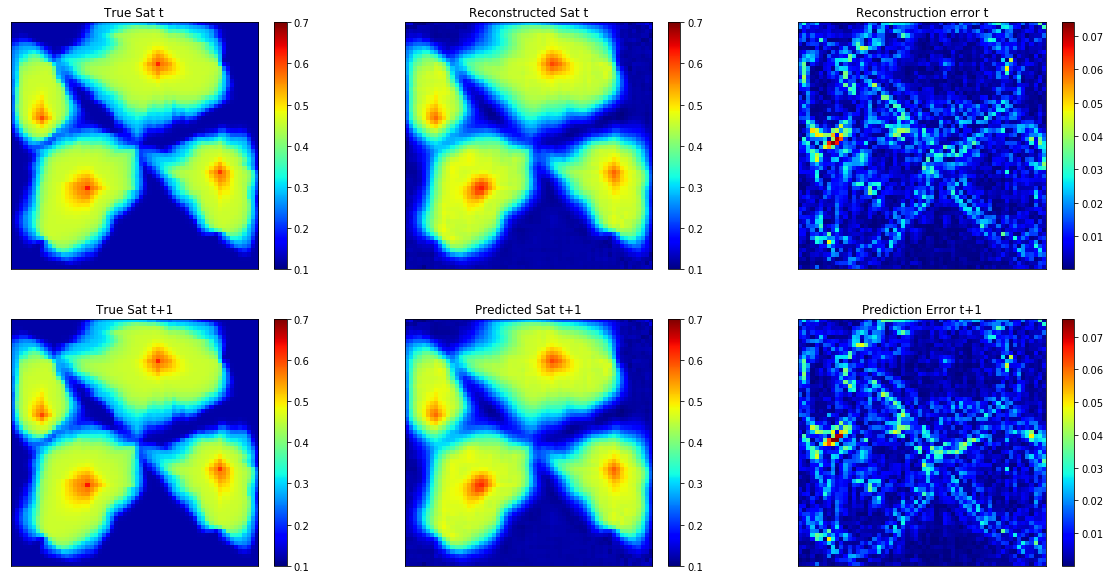

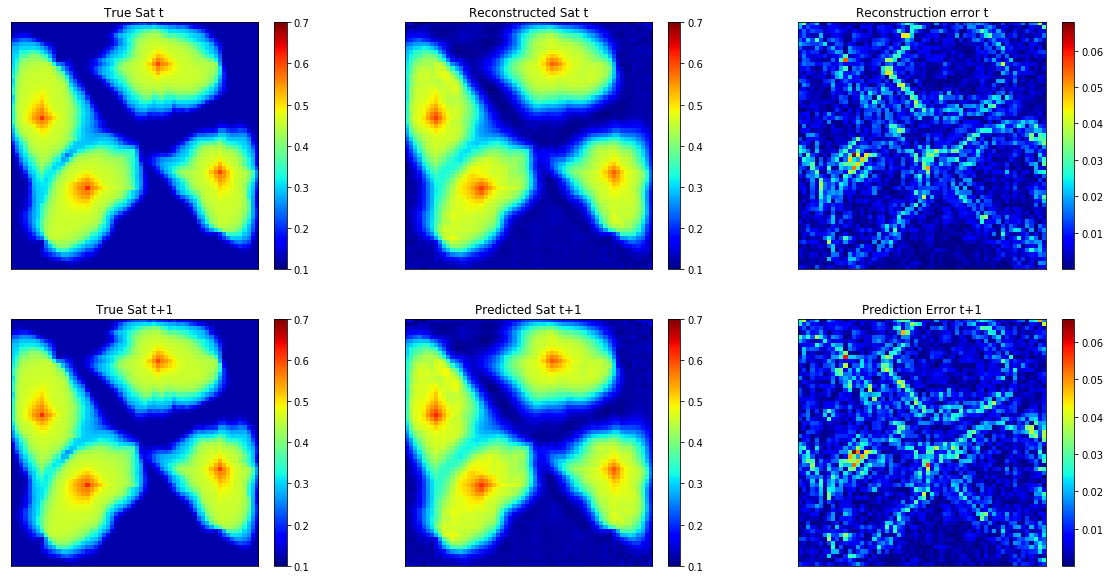

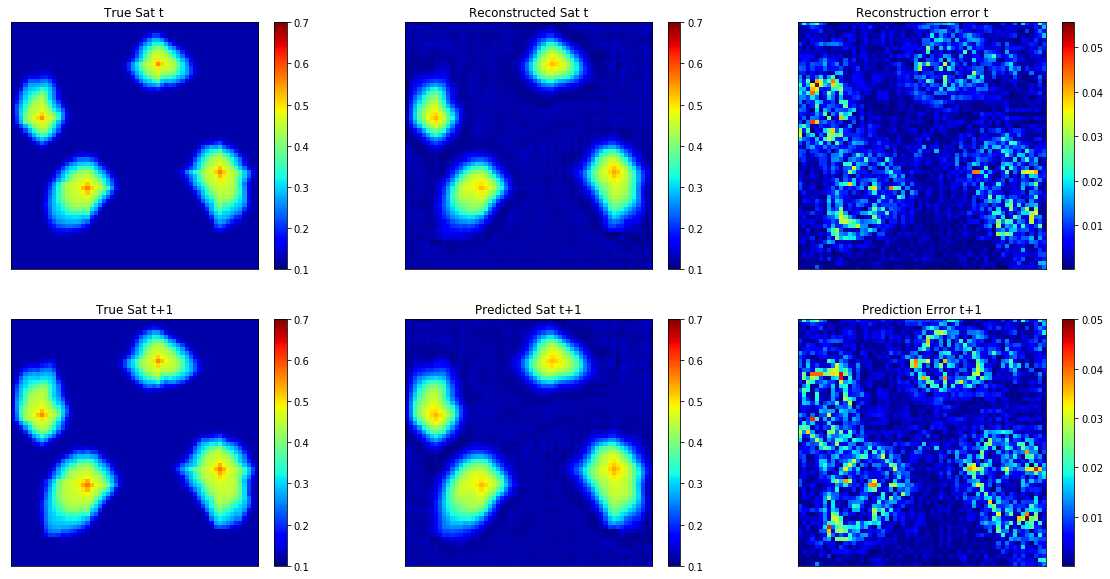

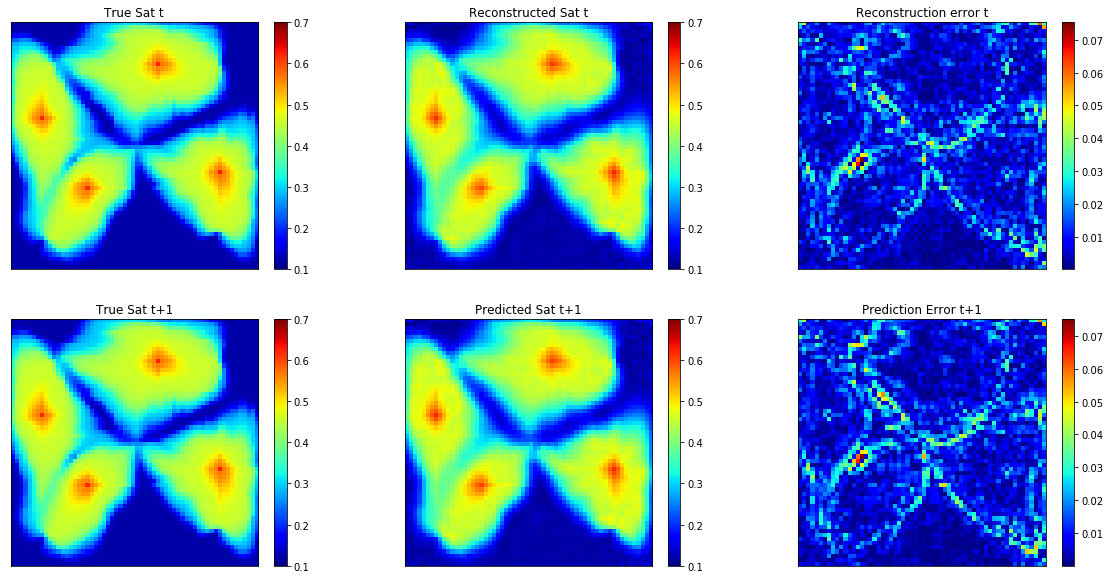

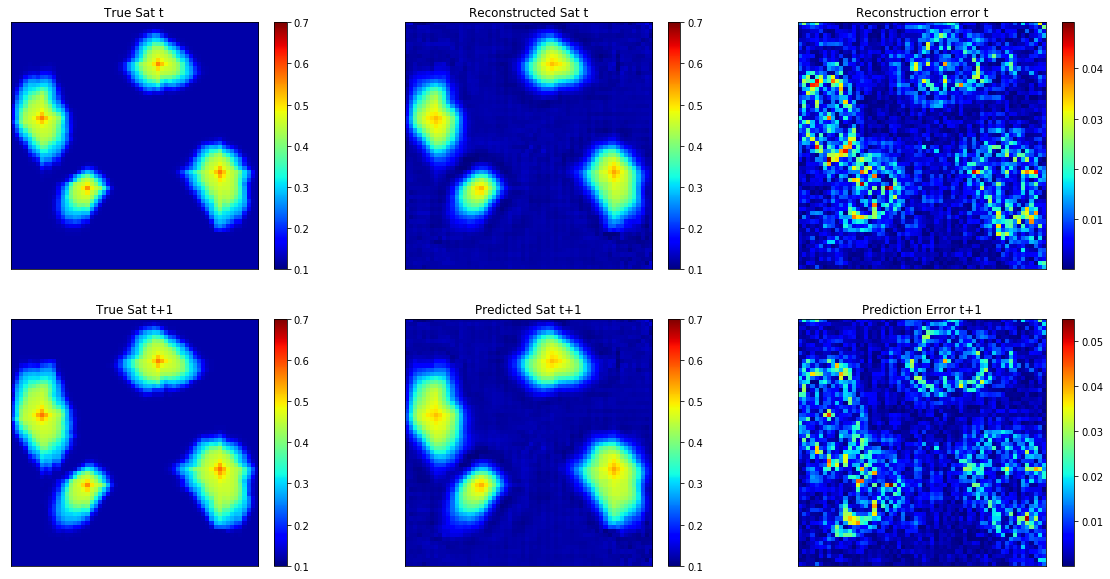

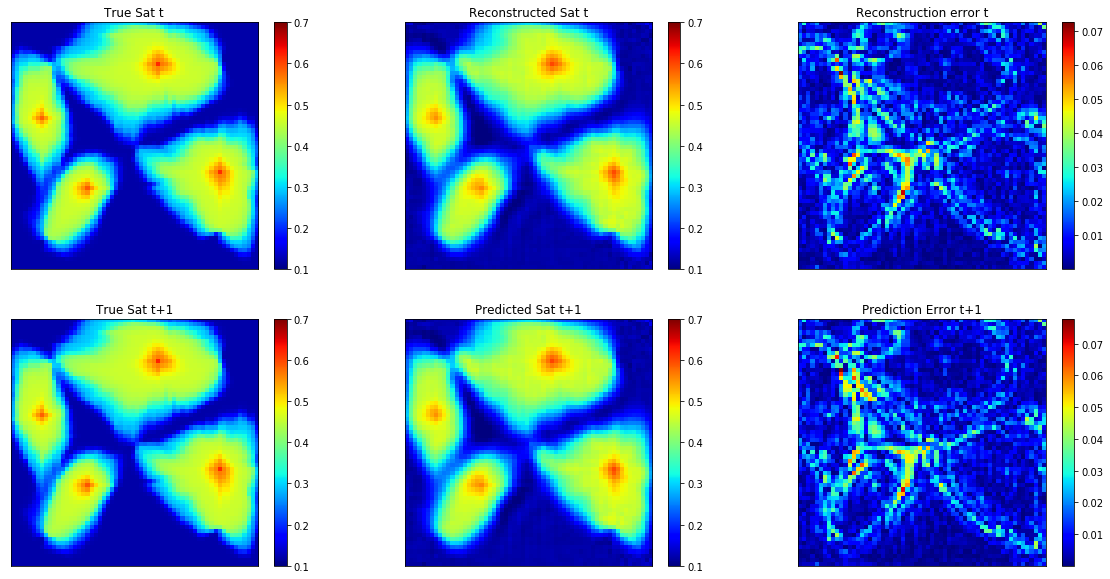

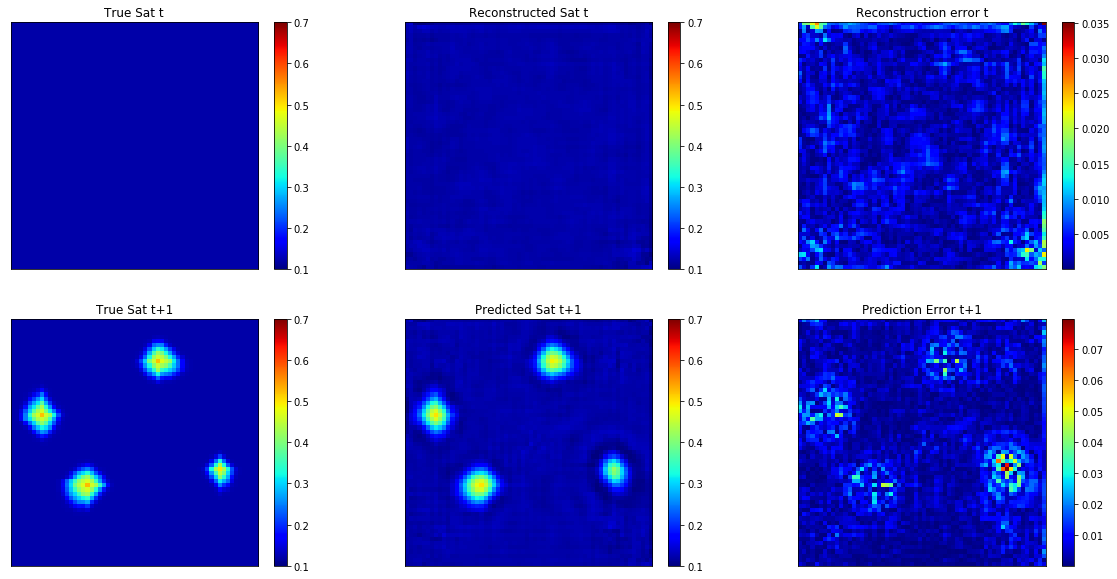

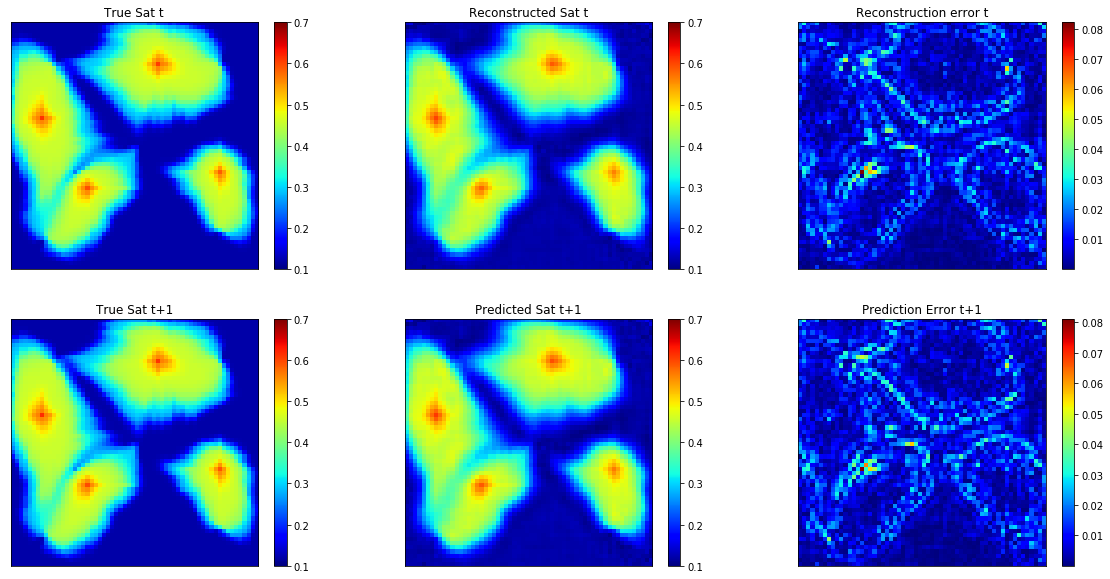

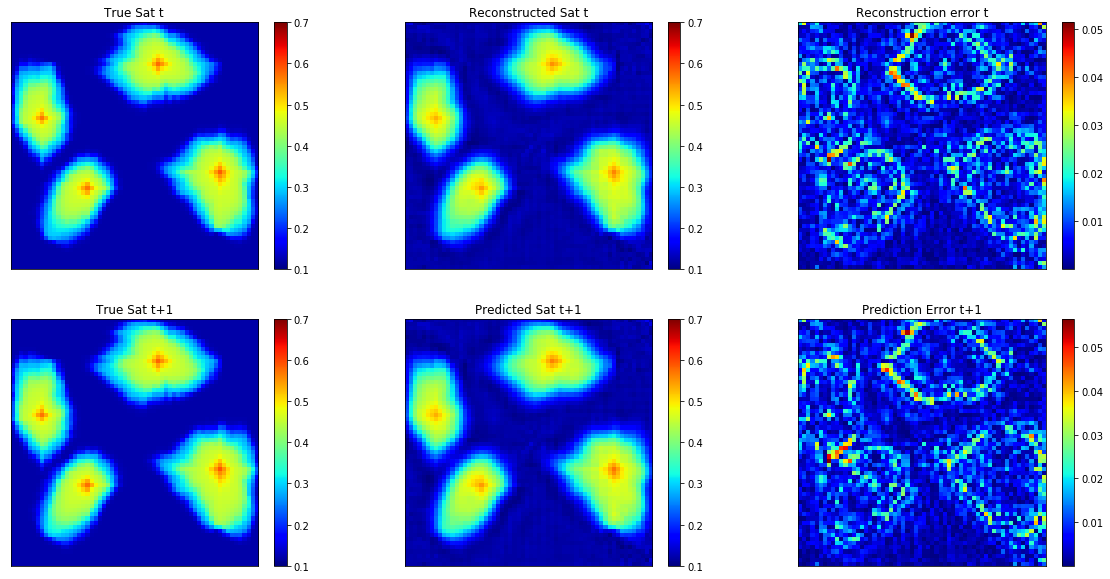

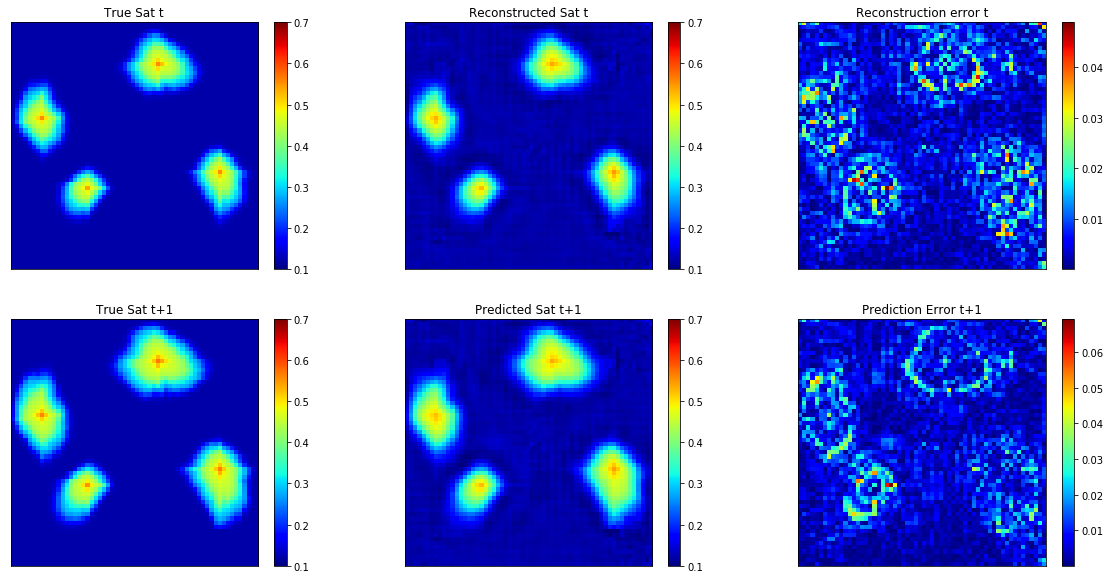

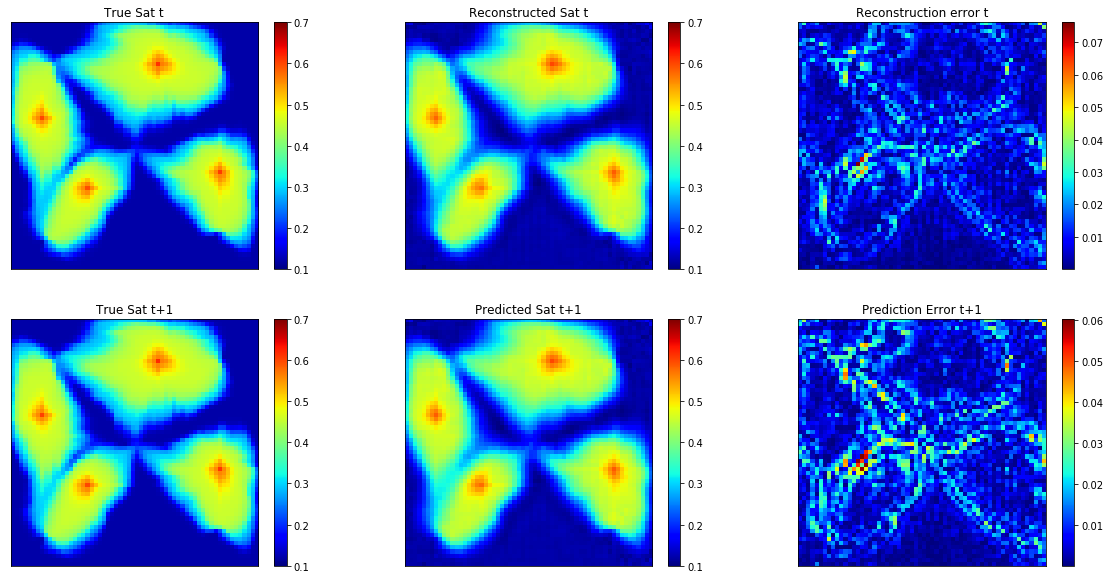

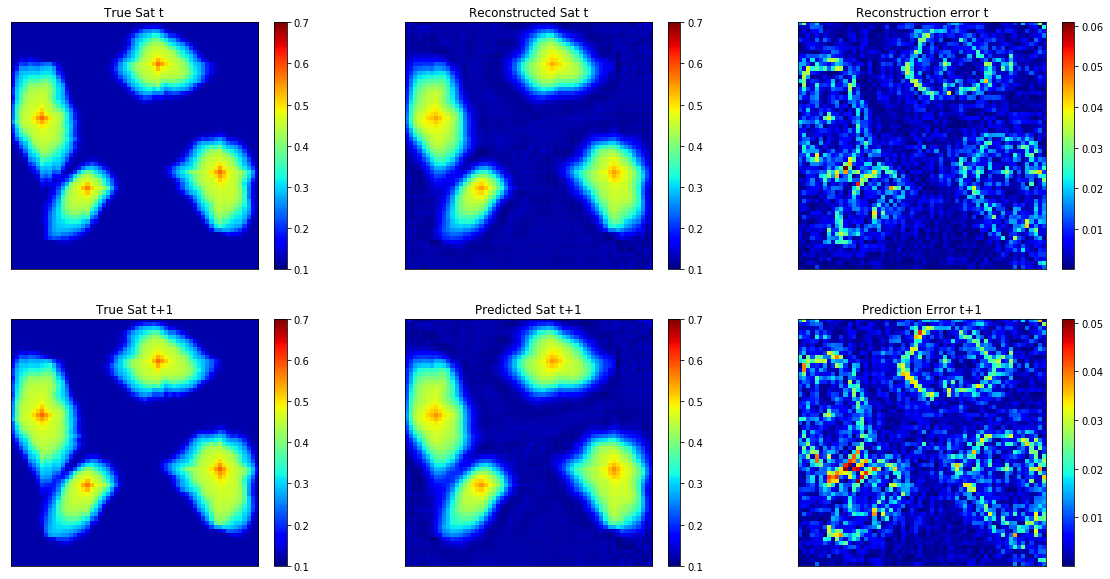

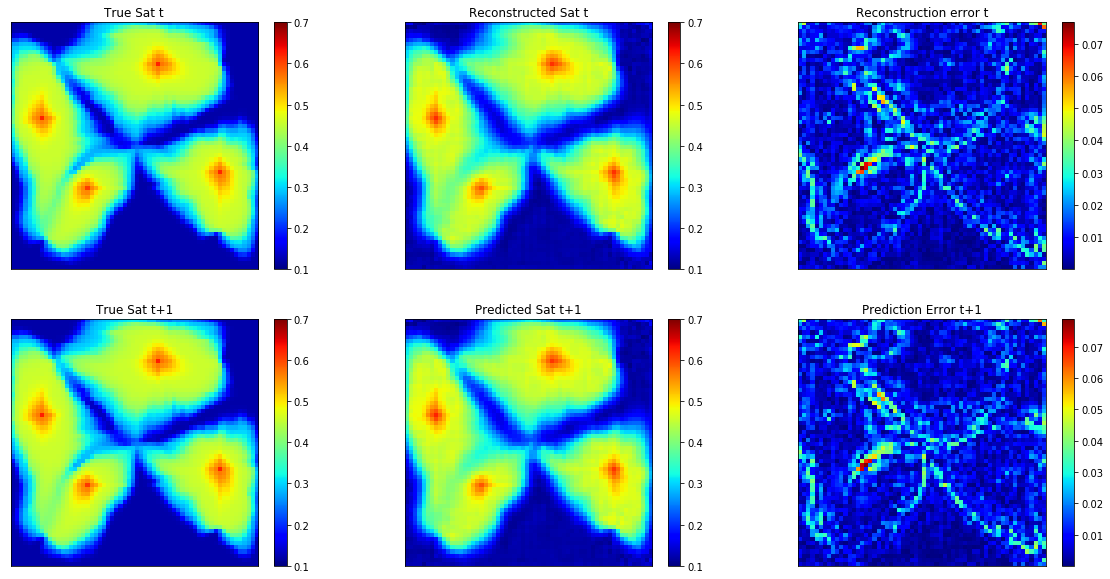

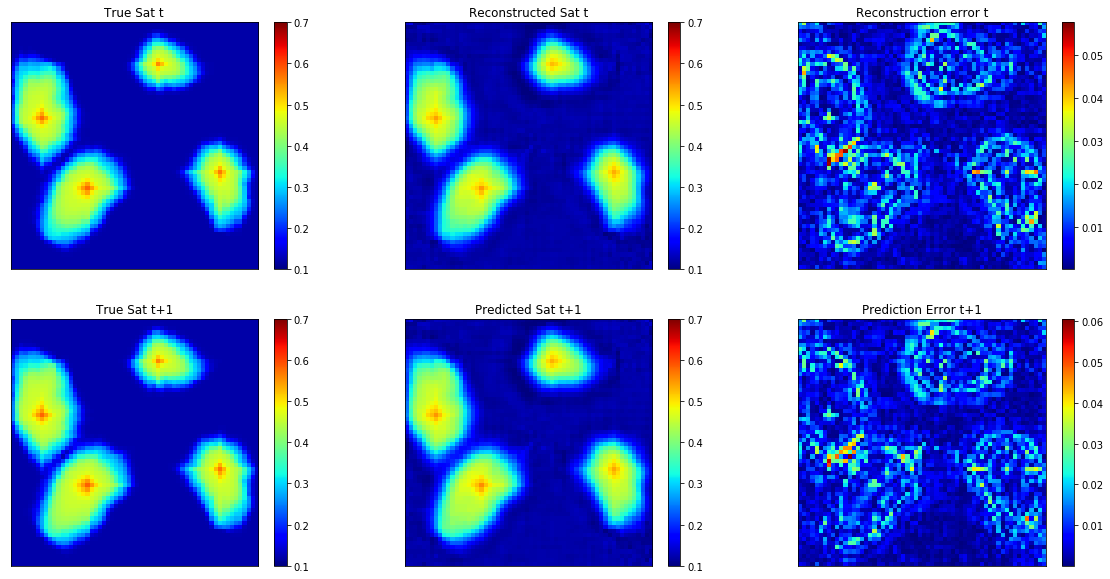

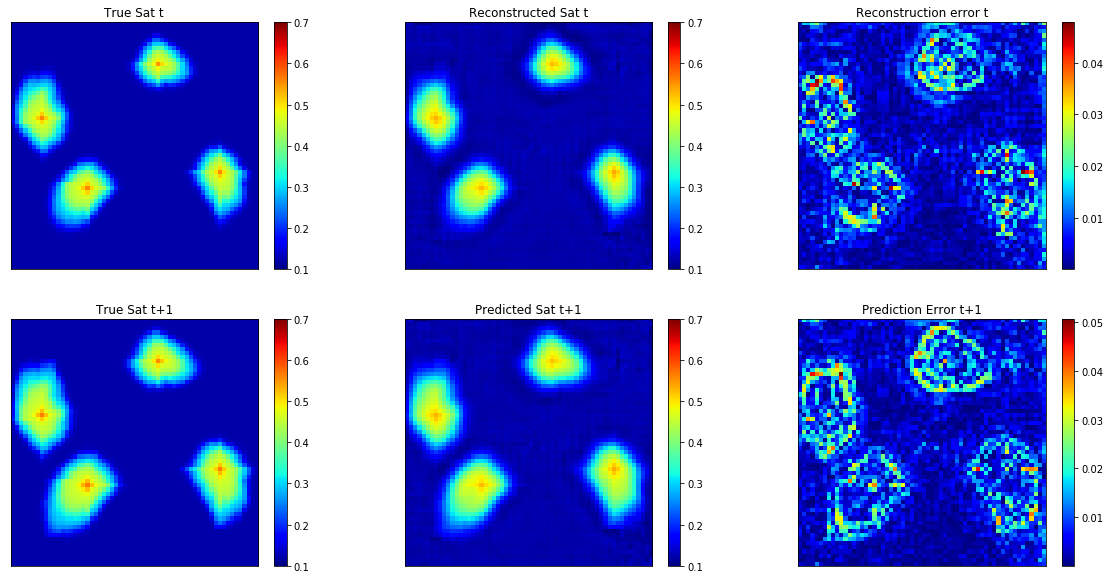

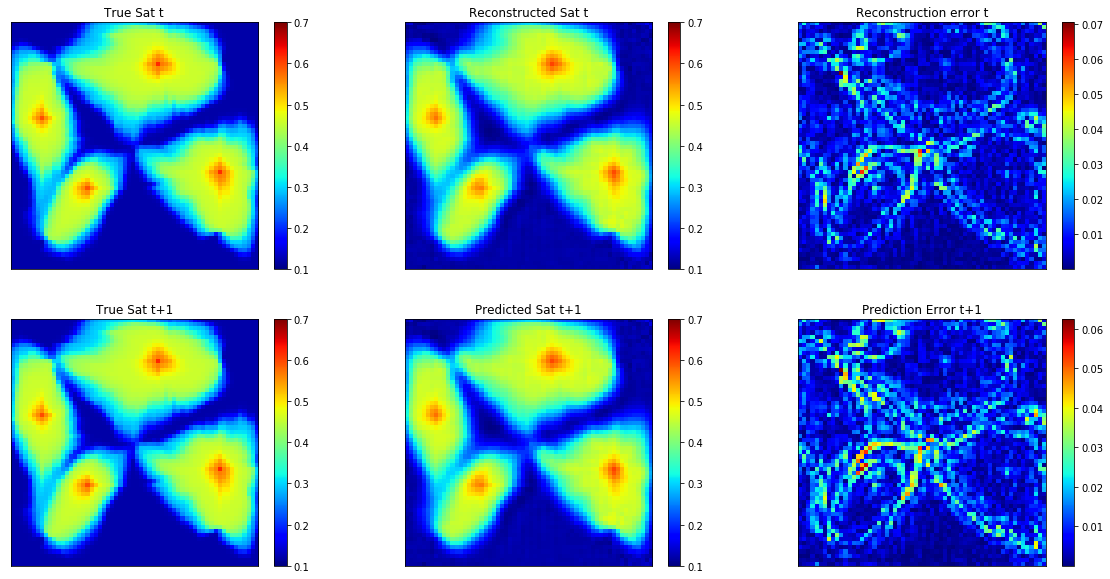

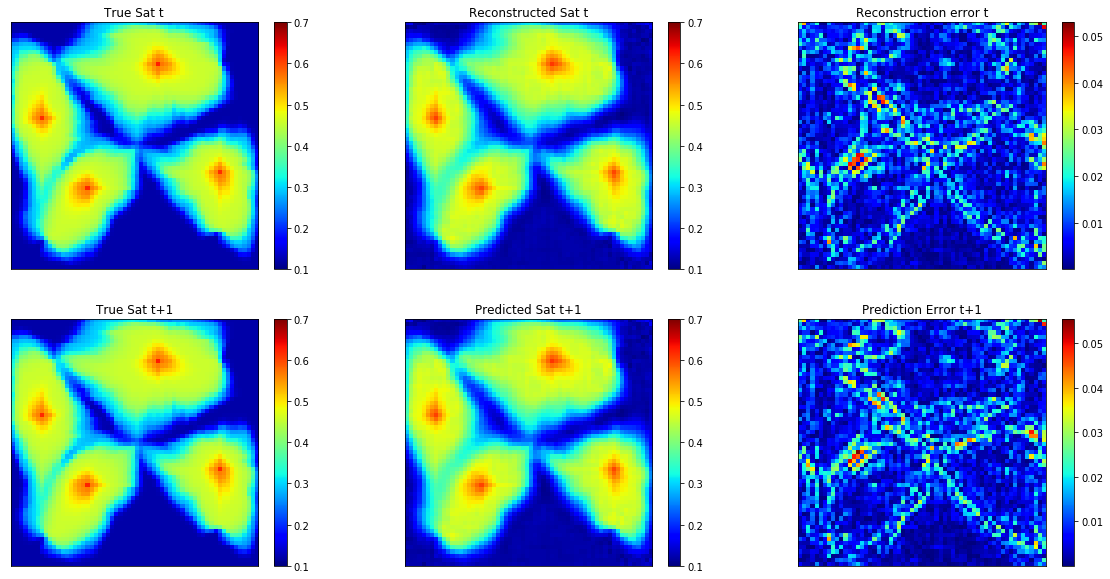

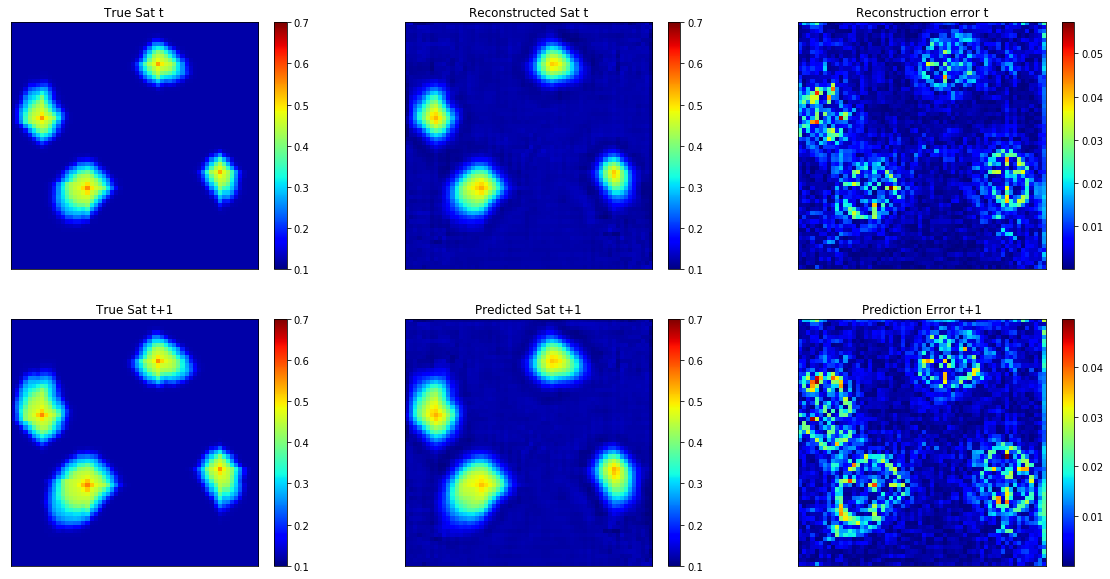

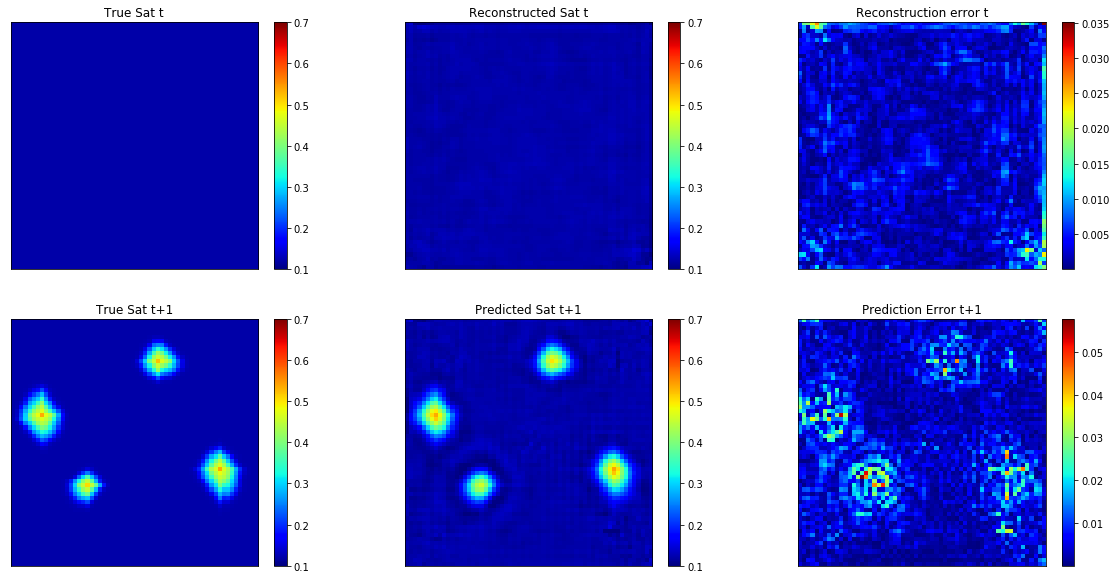

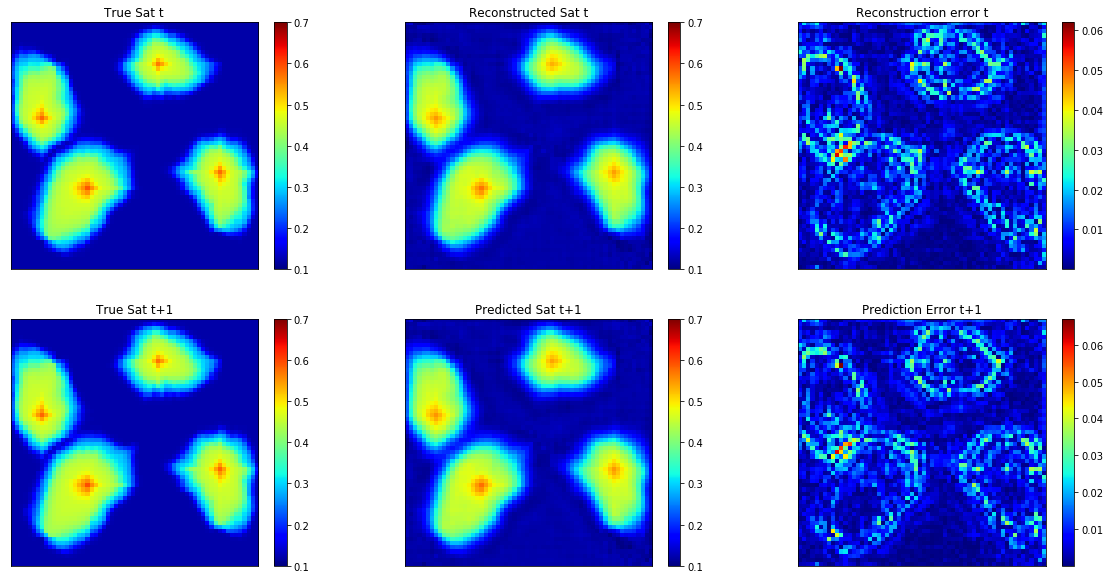

In [14]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Sat t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec_plot[k, :, :, 0] - state_t_eval_plot[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Sat t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred_plot[k, :, :, 0] - state_t1_eval_plot[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

### Step 3.2 Visualize single step result: pressure

In [15]:
p_max = 425
p_min = 250
p_diff = p_max - p_min

state_t_eval_plot = state_t_eval * p_diff + p_min
state_t_rec_plot = state_t_rec * p_diff + p_min
state_t1_eval_plot = state_t1_eval * p_diff + p_min
state_t1_pred_plot = state_t1_pred * p_diff + p_min

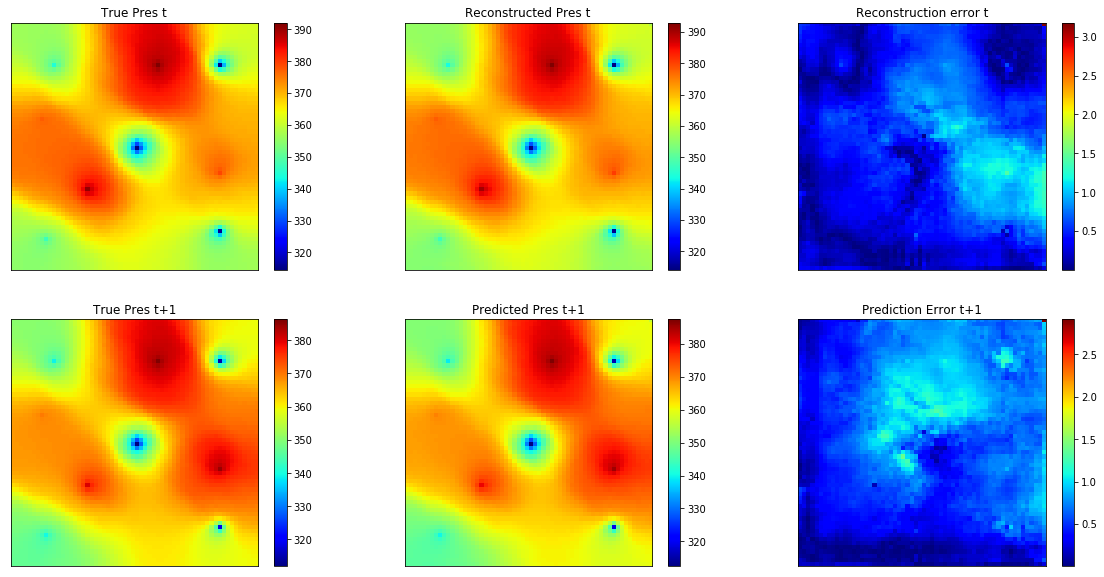

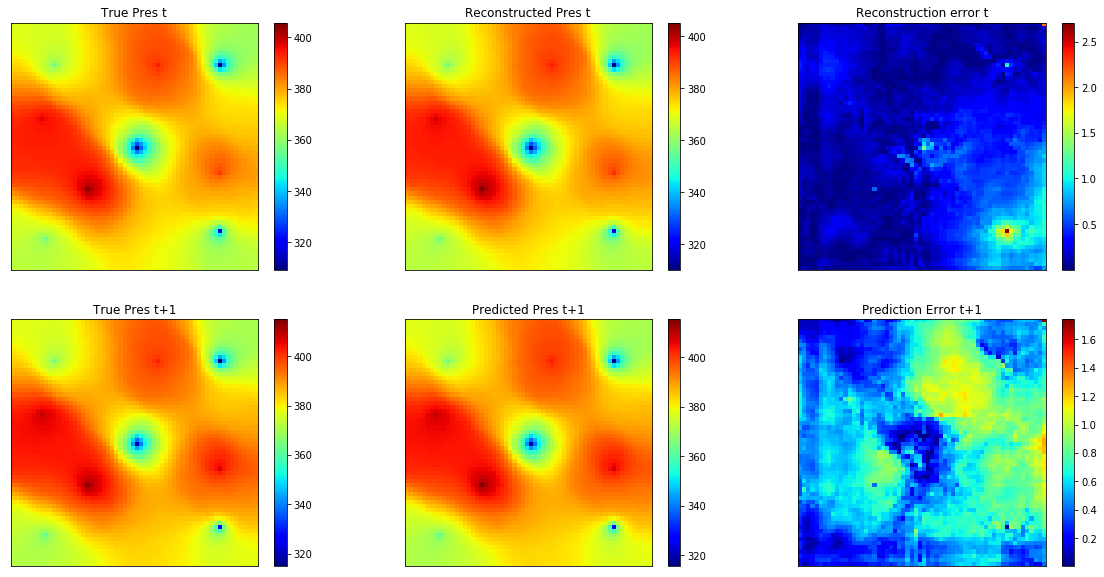

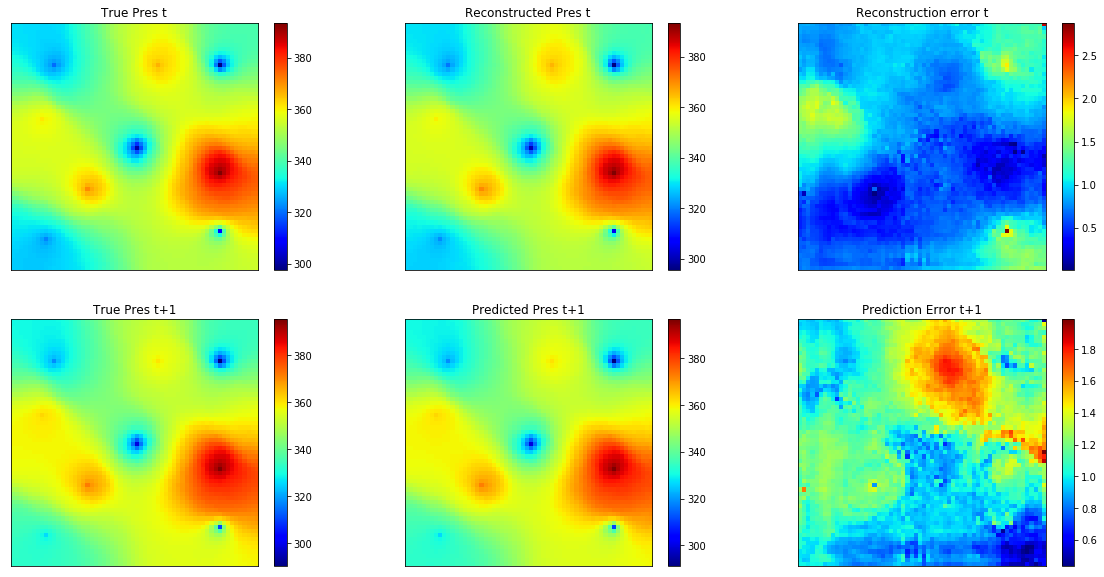

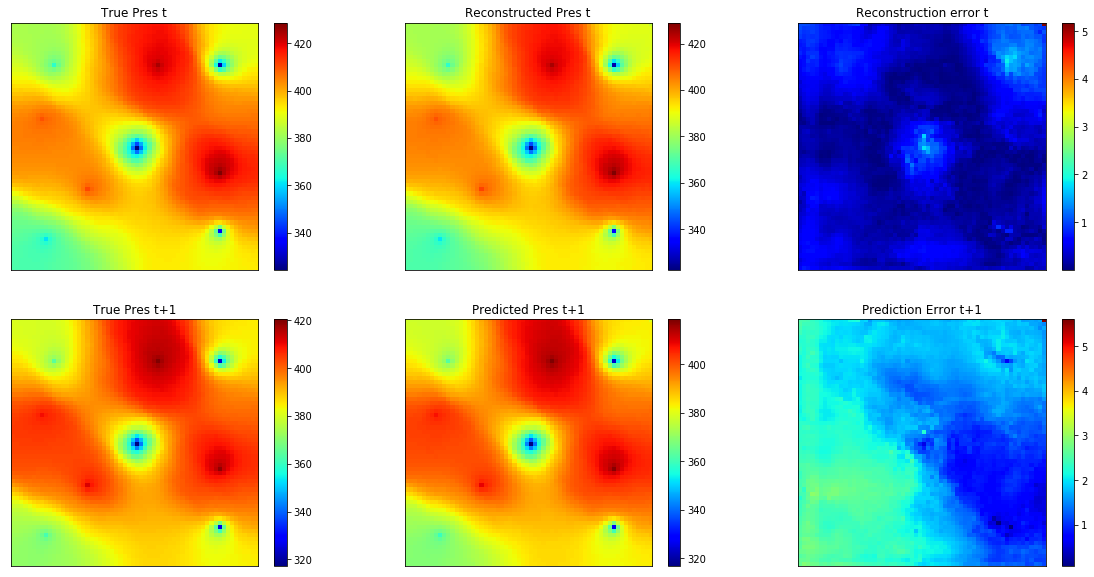

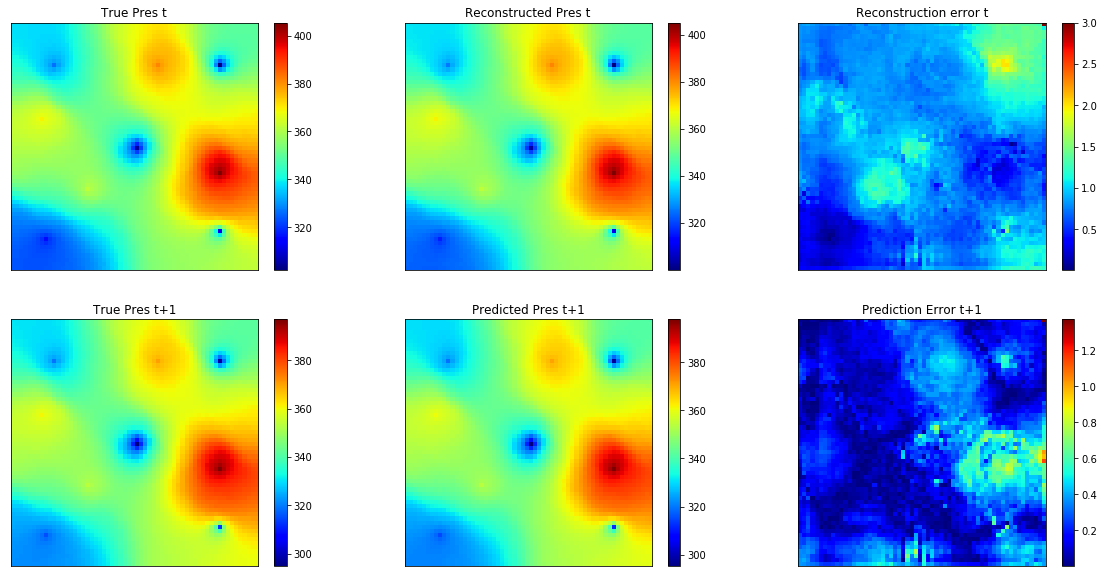

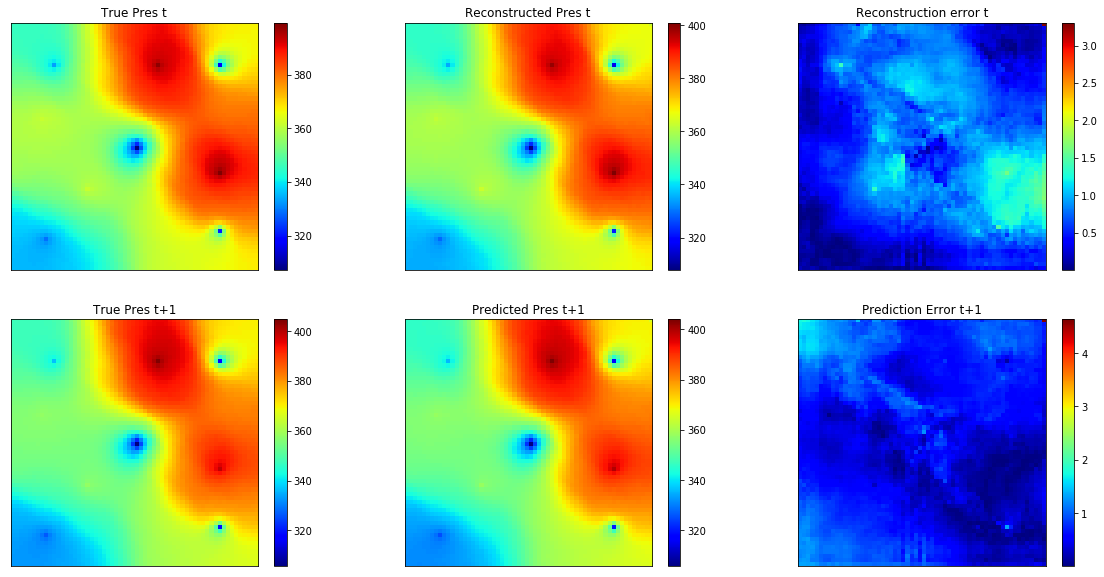

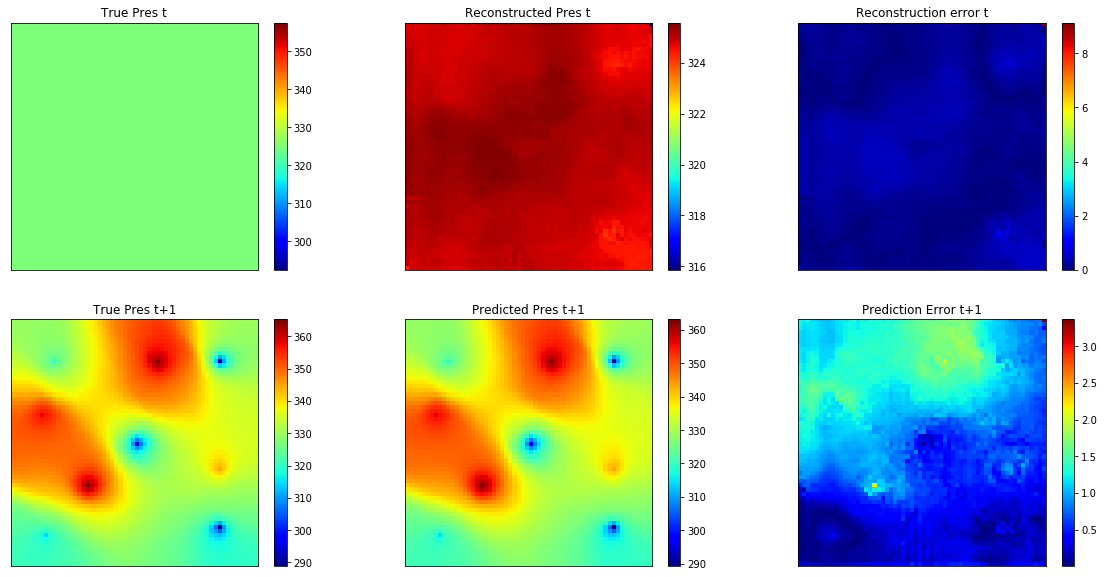

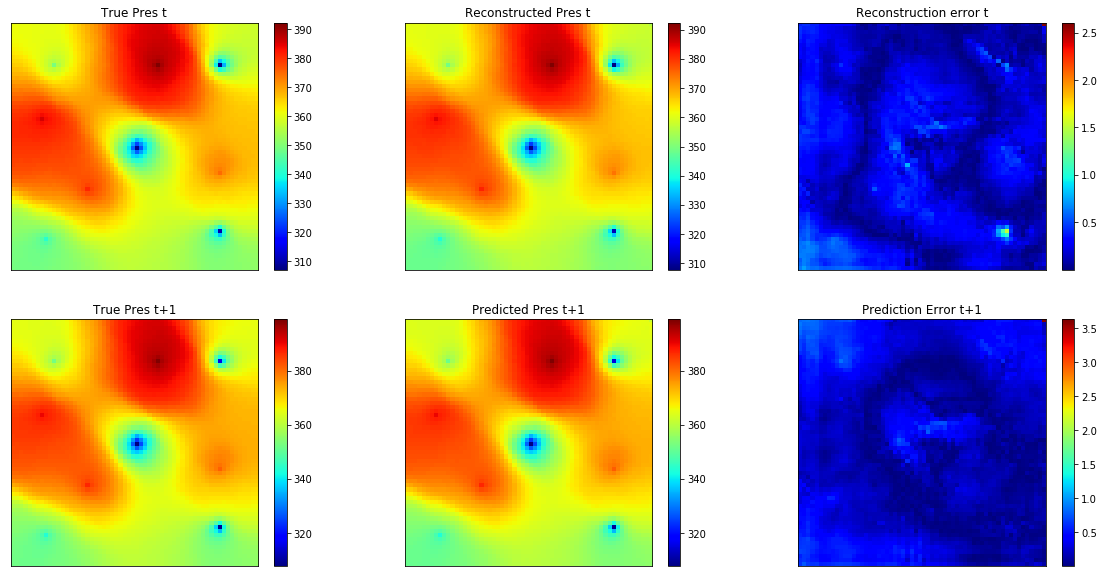

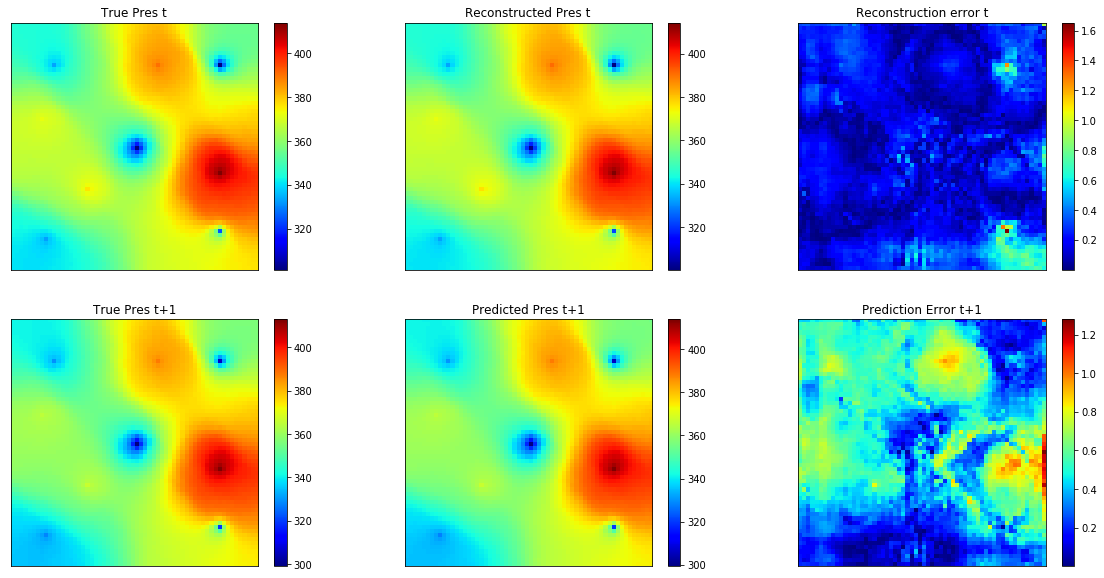

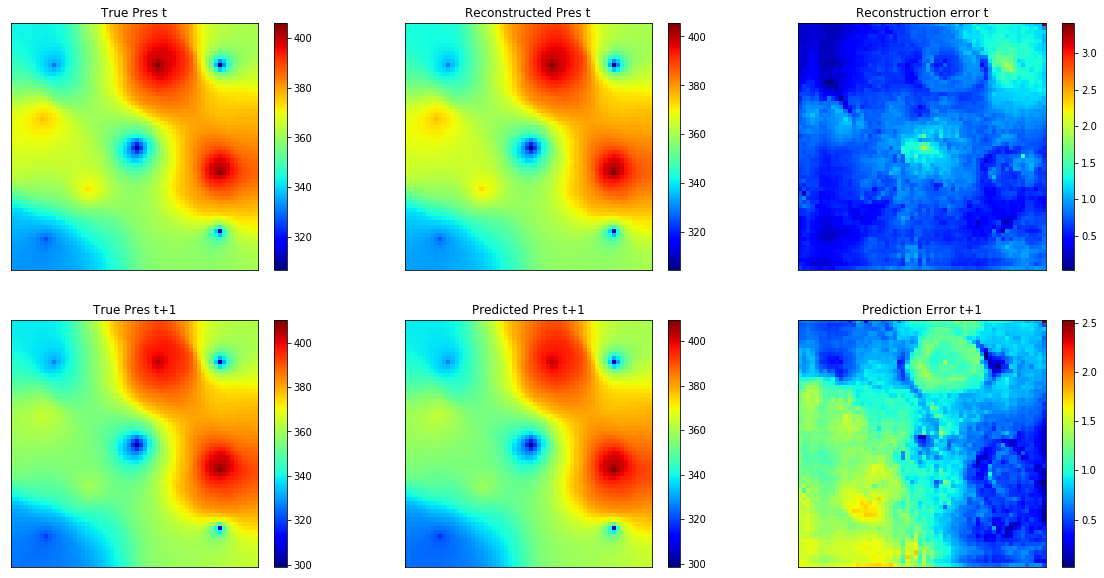

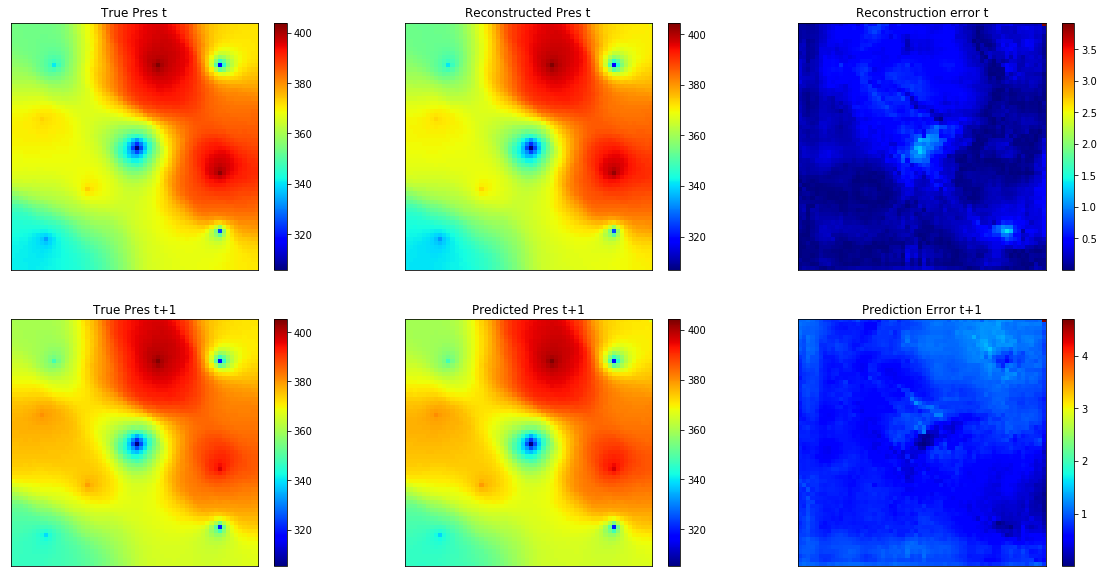

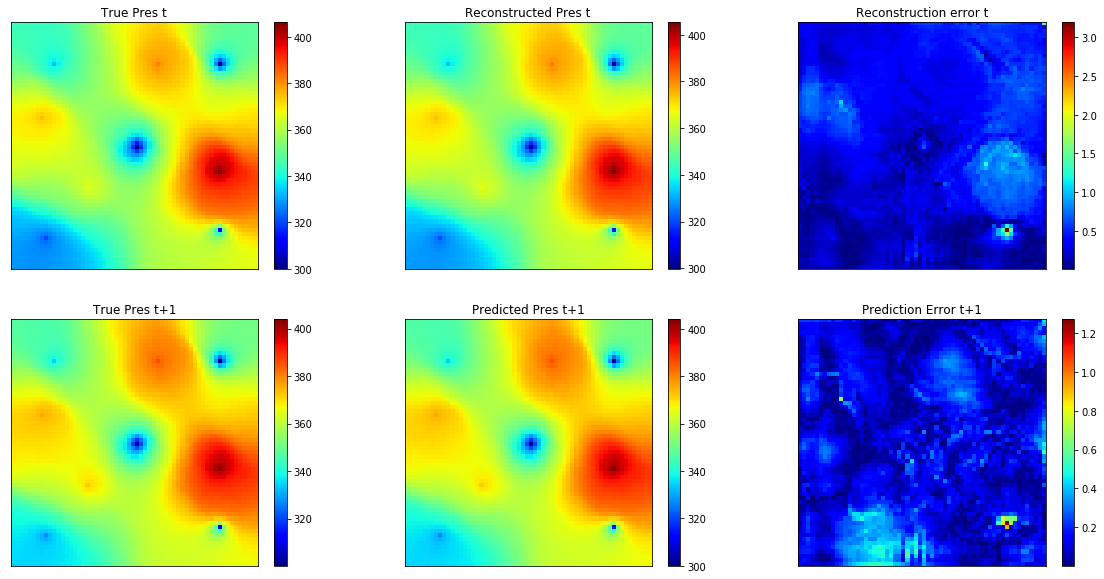

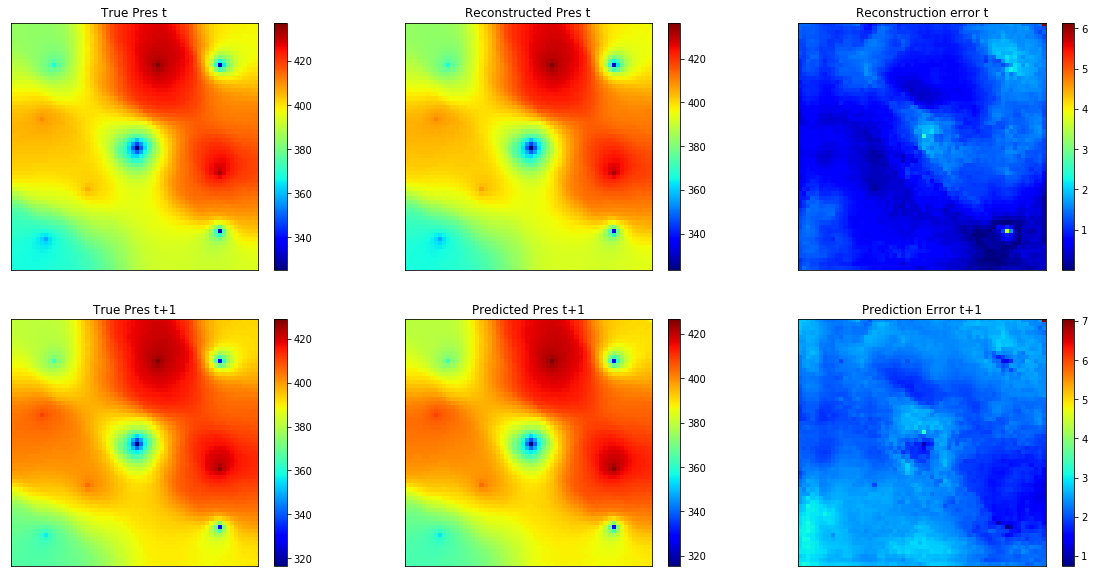

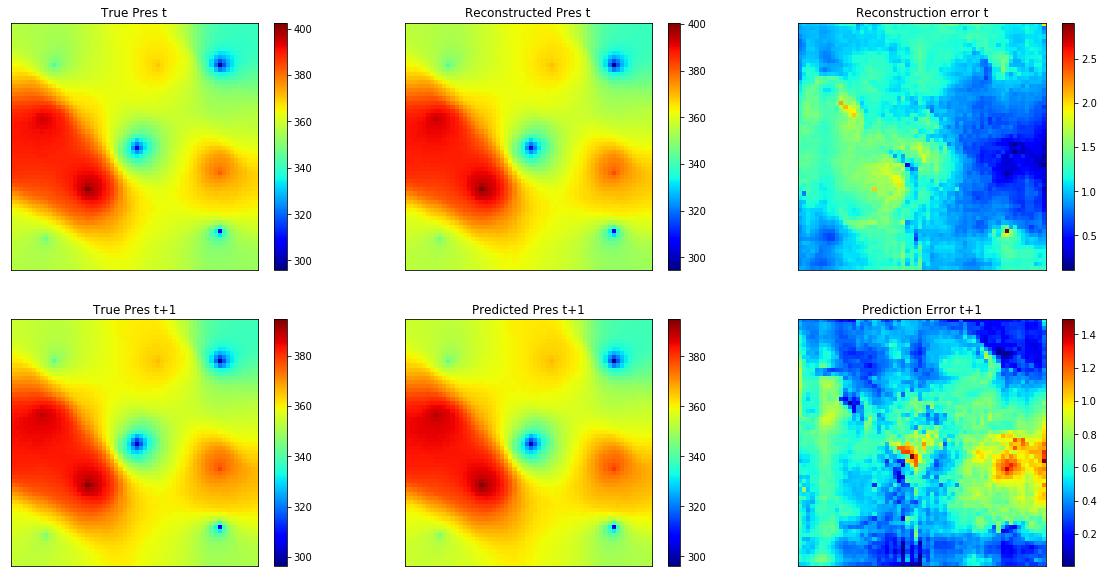

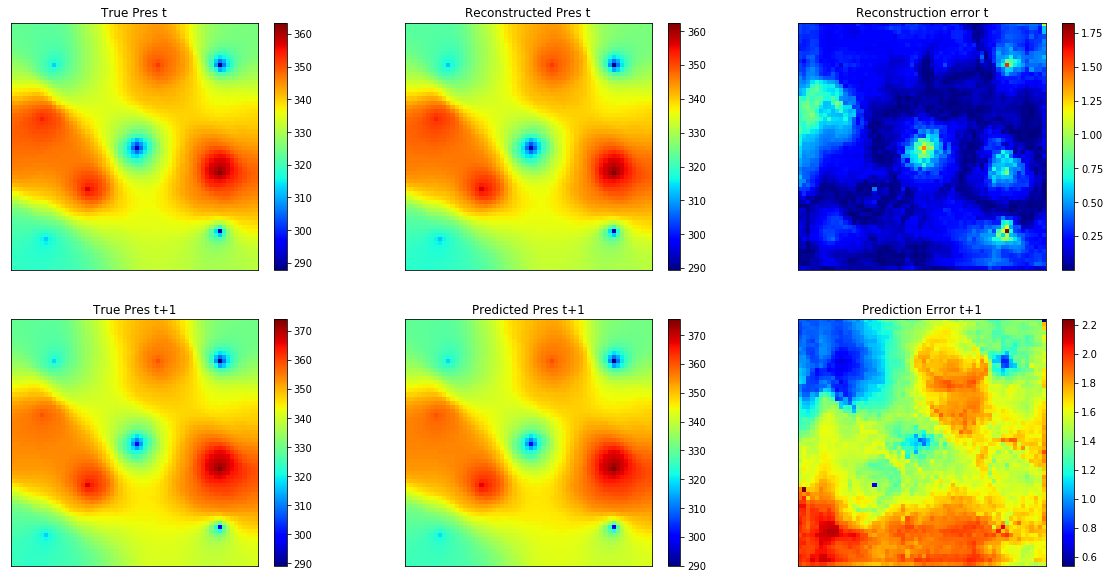

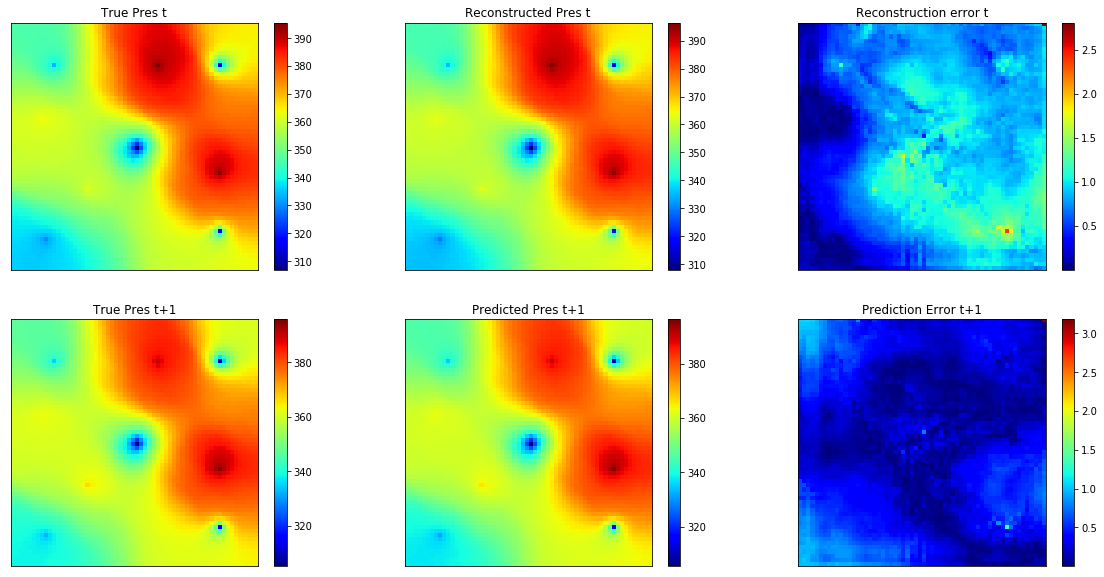

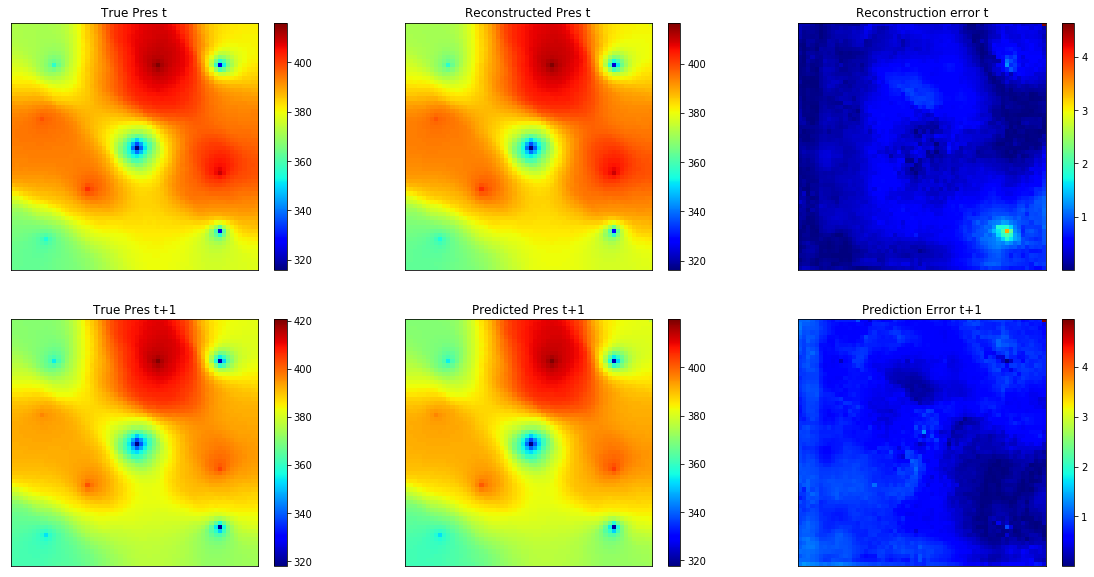

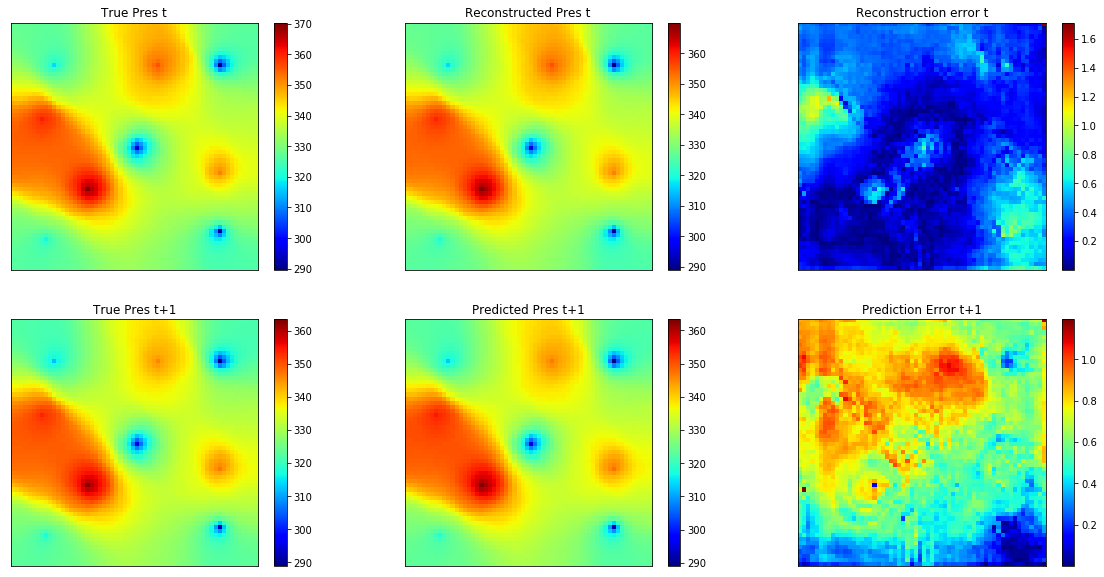

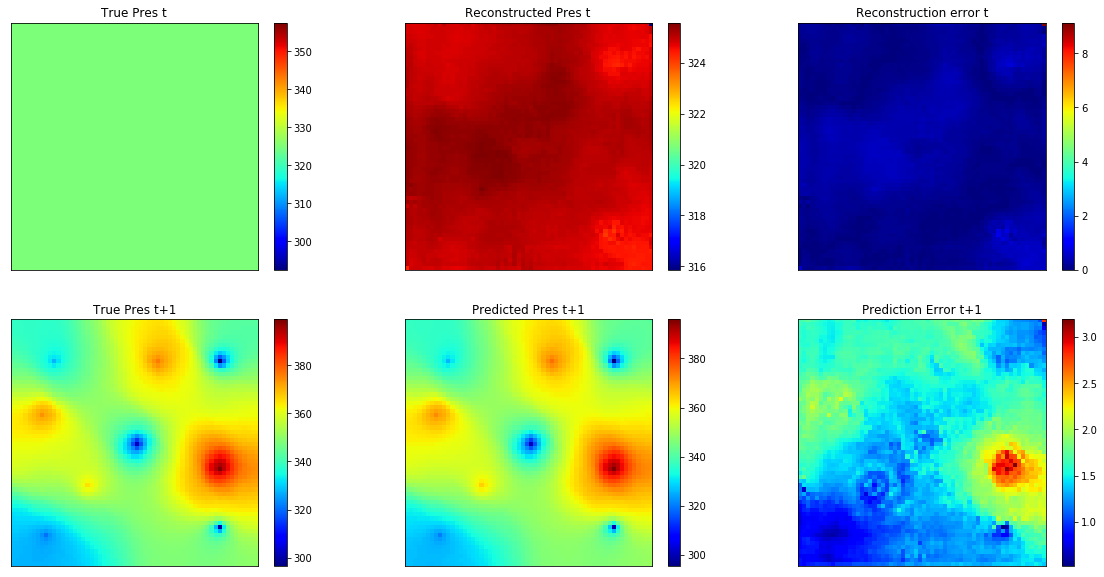

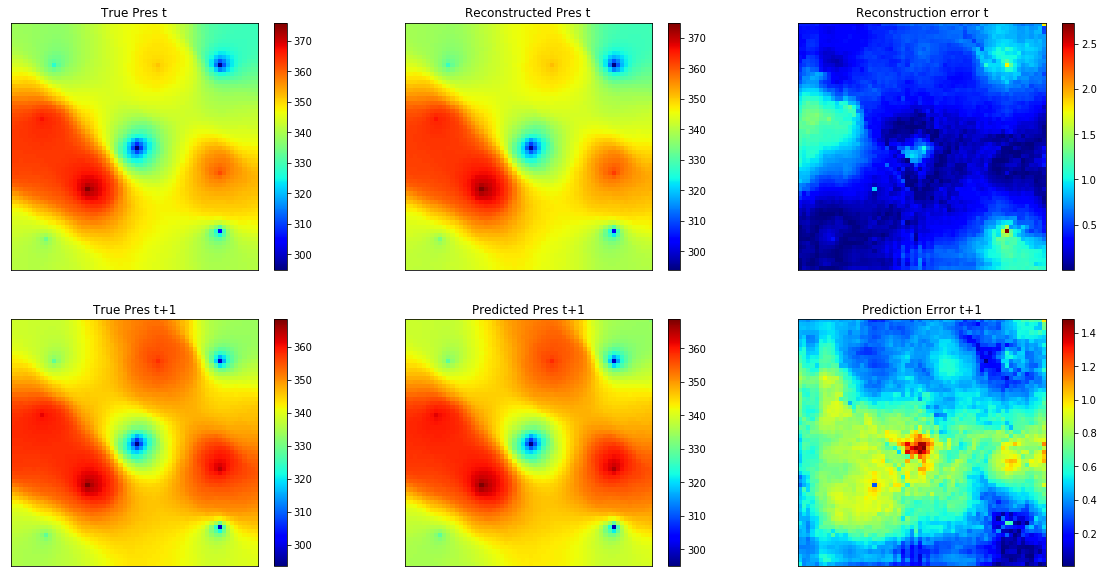

In [16]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Pres t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec_plot[k, :, :, 1] - state_t_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Pres t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred_plot[k, :, :, 1] - state_t1_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

## Step 4. Task II: E2C sequential prediction

## Step 4.1 Prepare data
#### Load and manipulate data

In [17]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
pres = np.array(hf_r.get('pres'))
hf_r.close()

In [18]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()

In [19]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 180)


In [31]:
sat = sat.T.reshape((400, 201, 3600))
pres = pres.T.reshape((400, 201, 3600))

In [20]:
test_case0 = np.zeros((25,4))
a = np.array(range(75,400,100))[np.newaxis,:]
b = np.array(range(25))[:,np.newaxis]

test_case = (test_case0 + a + b).T.reshape(100)
test_case = np.array(test_case).astype(int)

#### Pick 4 representative test cases to visualize  
Note here we have 100 test cases. In the E2C sequential workflow, prediction are done for all of them. However, to keep the notebook clean and short, we will only visualize a subset of 100.

In [21]:
ind_case = np.array([10, 25, 77, 97])

In [22]:
num_case = test_case.shape[0] # 4
num_tstep = 20
sat_pred = np.zeros((num_case, num_tstep, 60, 60, 1))
pres_pred = np.zeros((num_case, num_tstep, 60, 60, 1))

num_prod = 5
num_inj = 4
num_well = num_prod + num_inj

num_all_case = 400
num_ctrl = 20

Specify timesteps, time intervals, etc.

In [29]:
dt = 10
t_steps1 = (t_steps + dt).astype(int)

indt_del = t_steps1 - t_steps
indt_del = indt_del / max(indt_del)

tmp = np.array(range(num_tstep)) - 1
tmp1 = np.array(range(num_tstep))
tmp[0] = 0


[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


#### Reshape the input data to a proper format, so that it can be easily consumed by E2C model

In [23]:
t_steps = np.arange(0,200,200//num_tstep)

dt = 10
t_steps1 = (t_steps + dt).astype(int)

indt_del = t_steps1 - t_steps
indt_del = indt_del / max(indt_del)

tmp = np.array(range(num_tstep)) - 1
tmp1 = np.array(range(num_tstep))
tmp[0] = 0

In [36]:
bhp_b0 = bhp.reshape(num_all_case, num_well, num_ctrl)
bhp_b1 = np.repeat(bhp_b0[..., np.newaxis], num_tstep // num_ctrl, axis=3)
assert num_tstep // num_ctrl * num_ctrl == num_tstep, "no exaxt division num_step = %d, num_ctrl=%d"%(num_tstep, num_ctrl)

bhp_b2 = bhp_b1.reshape(num_all_case, num_well, num_tstep)

bhp_tt = bhp_b2[:,:, tmp]
bhp_tt1 = bhp_b2[:,:, tmp1]

bhp_tt0 = np.concatenate((bhp_tt, bhp_tt1), axis=1)
bhp_t = np.swapaxes(bhp_tt0,1,2)

bhp_seq = bhp_t[test_case, :, :]

In [37]:
sat_t_seq = sat[test_case, 0, :].reshape((num_case, 60, 60, 1)) # 4 here is the 4th timestep, t = 8
pres_t_seq = pres[test_case, 0, :].reshape((num_case, 60, 60, 1))

state_t_seq = np.concatenate((sat_t_seq, pres_t_seq),axis=3)
state_pred = np.concatenate((sat_pred, pres_pred),axis=4)

### Step 4.2 E2C sequential workflow

In [38]:
start = timeit.default_timer()

for i_tstep in range(num_tstep):
    state_pred[:, i_tstep, ...] = state_t_seq.copy()
    dt_seq = np.ones((num_case,1)) * indt_del[i_tstep]
    [_, state_t1_seq] = e2c_model.predict([state_t_seq, bhp_seq[:,i_tstep,:], dt_seq])
    state_t_seq = state_t1_seq.copy()

end = timeit.default_timer()

print("Time for sequential process: %f" %(end - start))

Time for sequential process: 1.232053


In [39]:
# sat_seq_true = sat[test_case[ind_case], ...]
sat_seq_true = sat[test_case, ...]
sat_seq_true = sat_seq_true[:, list(np.arange(0,200,10)), :]

# pres_seq_true = pres[test_case[ind_case], ...]
pres_seq_true = pres[test_case, ...]
pres_seq_true = pres_seq_true[:, list(np.arange(0,200,10)), :]
state_seq_true = np.zeros((len(test_case),20,3600,2))
state_seq_true[:,:,:,0] = sat_seq_true
state_seq_true[:,:,:,1] = pres_seq_true

### Step 4.3 Visualization for saturation

In [40]:
sat_pred_plot = state_pred[:, :, :, :, 0] * s_diff + s_min
state_pred[:, :, :, :, 0] = state_pred[:, :, :, :, 0] * s_diff + s_min

Case num: 10


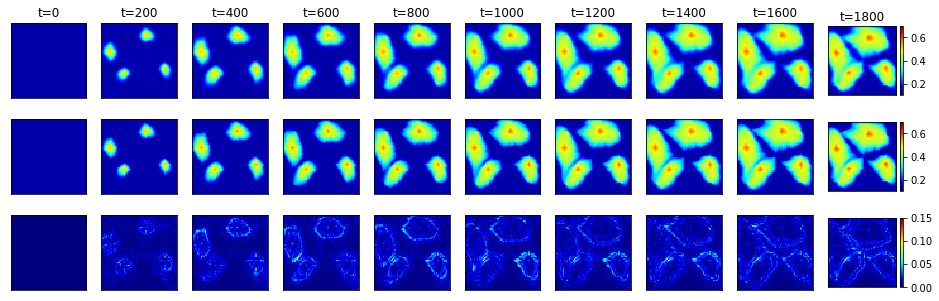

Case num: 25


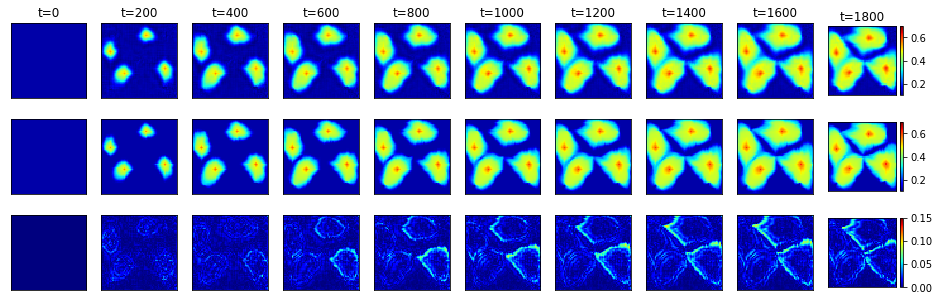

Case num: 77


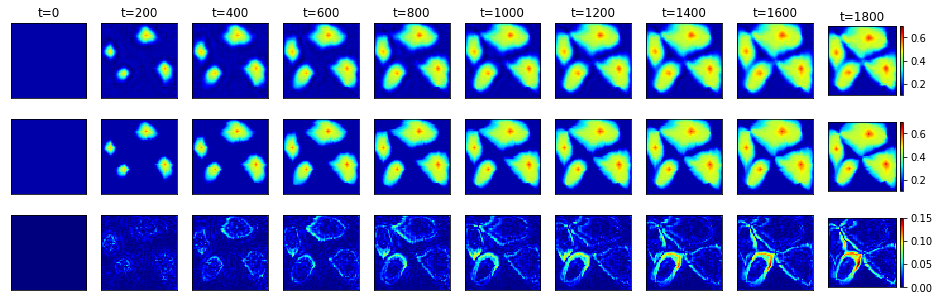

Case num: 97


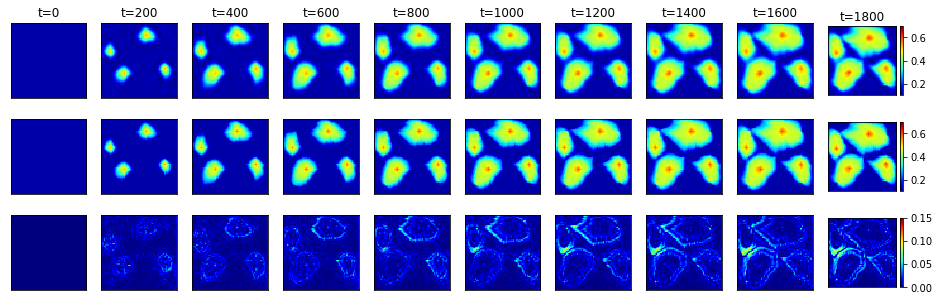

In [41]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)) - sat_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

### Step 4.4 Visualization for pressure

In [42]:
state_pred_plot = state_pred[:, :, :, :, 1] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, :, :, 1] * p_diff + p_min

Case num: 10


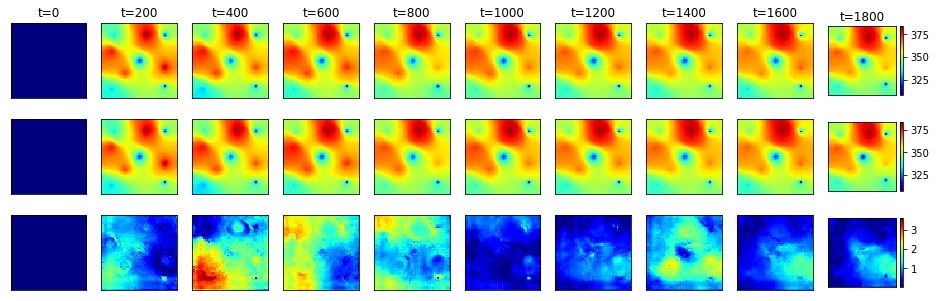

Case num: 25


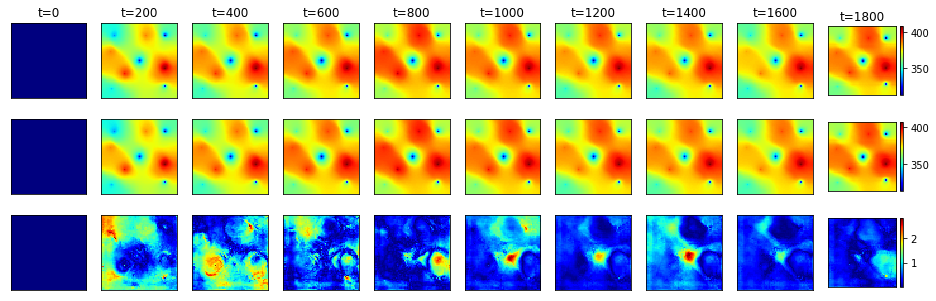

Case num: 77


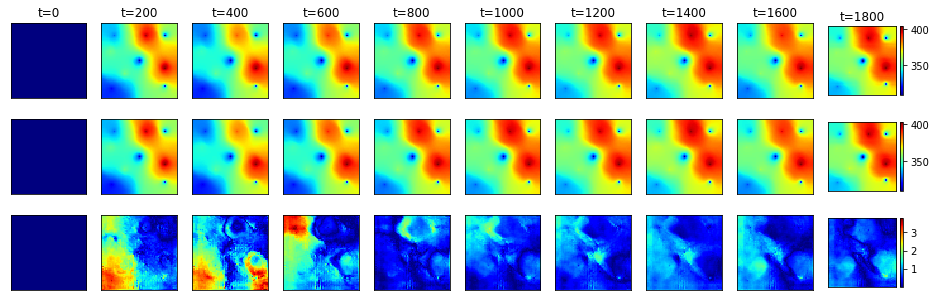

Case num: 97


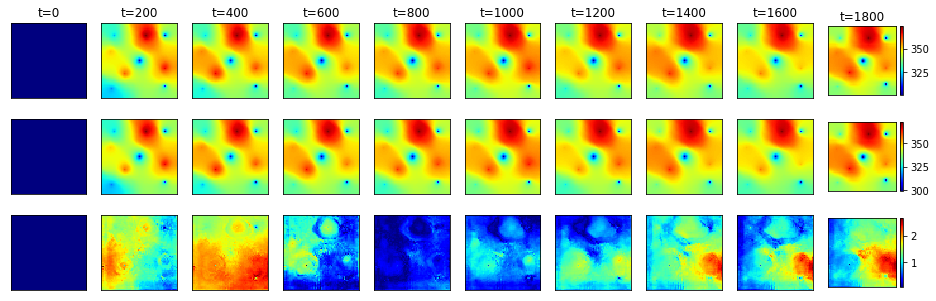

In [43]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred_plot[ind_case[k], i_tstep*divide, :, :])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)) - state_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

## Step 4.5 Reshape the output data and save to `result/`

In [44]:
train_case0 = np.zeros((75,4))
a = np.array(range(0,400,100))[np.newaxis,:]
b = np.array(range(75))[:,np.newaxis]

train_case = (train_case0 + a + b).T.reshape(300)
train_case = np.array(train_case)

In [45]:
sat_seq_train0 = sat[train_case.astype(int), :, :] 
pres_seq_train0 = pres[train_case.astype(int), :, :]
sat_seq_train = sat_seq_train0[:, np.arange(0,200,10), :]
pres_seq_train = pres_seq_train0[:, np.arange(0,200,10), :]
state_seq_train = np.zeros((300,20,3600,2))
state_seq_train[:,:,:,0] = sat_seq_train
state_seq_train[:,:,:,1] = pres_seq_train

In [46]:
bhp_train = bhp[train_case.astype(int),:]
bhp_eval = bhp[test_case.astype(int),:]

In [49]:
# ===== chose 1 of the following 2 =====
### old case may not have model_suffix in the result filename ###
output_dir = '../result/9w_ms_bhp_rate_fix_wl/'
hf_w = h5py.File(output_dir + case_name + target_suffix + model_suffix + '_nt_%d_state_seq_pred_ctrl.mat'%(num_train), 'w')

### new case ###
# output_dir = '/data3/Astro/lstm_rom/e2c_larry/data/' + case_name + '/'
# hf_w = h5py.File(output_dir + case_name + target_suffix + model_suffix + '_nt_%d_state_seq_pred_ctrl.mat'%(num_train), 'w')

# ====== end of chose =====
hf_w.create_dataset('true_seq', data=state_seq_true)
hf_w.create_dataset('pred_seq', data=state_pred)
hf_w.create_dataset('train_seq', data=state_seq_train)
hf_w.create_dataset('ctrl_seq', data=bhp_seq)
hf_w.create_dataset('train_ctrl', data=bhp_train)
hf_w.create_dataset('eval_ctrl', data=bhp_eval)
hf_w.close()